In [1]:
#!/usr/bin/env julia
# https://github.com/GTorlai/PastaQ.jl
using PastaQ
using ITensors
using Plots

In [2]:
function PastaQ.gate(::GateName"R"; theta::Real, phi::Real)
    [
        cos(theta/2)    (-im * exp(-im * phi) * sin(theta/2))
        (-im * exp(im * phi) * sin(theta/2))     cos(theta/2)
    ]
end

function PastaQ.gate(::GateName"M"; Theta::Real)
    [
        cos(Theta)    0    0    (-im * sin(Theta))
        0    cos(Theta)    (-im * sin(Theta))    0
        0    (-im * sin(Theta))    cos(Theta)    0
        (-im * sin(Theta))    0    0    cos(Theta)
    ]
end

function run(N, depth)
    # Random circuit.
    gates = Vector{Tuple}[]

    for i in 1:depth
        one_qubit_layer = Tuple[]
        two_qubit_layer = Tuple[]

        for j in 1:N
            gate = ("R", j, (theta=2pi*rand(), phi=2pi*rand()))
            push!(one_qubit_layer, gate)
        end

        # Alternate start qubit for pairs.
        idx_first = i % 2 + 1

        for j in idx_first:2:(N-1)
            gate = ("M", (j, j+1), (Theta=2pi*rand(),))
            push!(two_qubit_layer, gate)
        end

        push!(gates, one_qubit_layer)
        push!(gates, two_qubit_layer)
    end
    
    # returns the value of the last expression evaluated
    psi = runcircuit(N, gates)
end

run (generic function with 1 method)

# Task 1

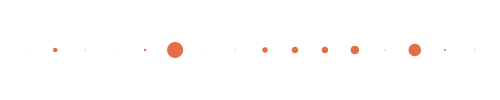

In [3]:
# N = parse(Int, ARGS[1])
# depth = parse(Int, ARGS[2])
N=4
depth = 5
psi = run(N, depth);

# Helpful Doc: https://github.com/ITensor/ITensors.jl/blob/v0.1.41/examples/gate_evolution/quantum_simulator.jl
# https://nbviewer.jupyter.org/github/goropikari/PlotsGallery.jl/blob/master/PlotsGallery.ipynb#Scatter-plot-2d
# https://docs.juliaplots.org/latest/colors/
s = siteinds("Qubit", N)
squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]

Plots.scatter([i for i in 1:2^N], zeros(2^N), 
    markersize=squared_mag*40,markercolor	=2,markerstrokecolor=2,
    ylims=(-0.5, 0.5), axis=false, ticks = false, size = (500, 100), legend=false)

# Task 2

In [84]:
function run_with_bit_flip_error(N, depth, theta1 = 0.55, phi1 = 0.62, theta2 = 0.07)
    bit_flip_qubit = rand(1:N)
    bit_flip_err = ("X", bit_flip_qubit)
    
    bit_flip_location = rand(1: floor(Int, N*depth + depth/2*(N-1))) # choose a random location among all operations  
#     print(bit_flip_location)
        
    # Random circuit.
    gates = Vector{Tuple}[]
    count=0 
    for i in 1:depth
        one_qubit_layer = Tuple[]
        two_qubit_layer = Tuple[]
        
        for j in 1:N
            gate = ("R", j, (theta=2pi*theta1, phi=2pi*phi1))            
            push!(one_qubit_layer, gate)           
            
            count += 1
            if count == bit_flip_location
                push!(one_qubit_layer, bit_flip_err)  
            end            
            
        end

        # Alternate start qubit for pairs.
        idx_first = i % 2 + 1

        for j in idx_first:2:(N-1)
            gate = ("M", (j, j+1), (Theta=2pi*theta2,))
            push!(two_qubit_layer, gate)
            count += 1
            if count == bit_flip_location
                push!(one_qubit_layer, bit_flip_err)  
            end
        end

        push!(gates, one_qubit_layer)
        push!(gates, two_qubit_layer)
    end
    
    # returns the value of the last expression evaluated
    psi = runcircuit(N, gates)
    return psi, bit_flip_qubit, bit_flip_location
end

run_with_bit_flip_error (generic function with 4 methods)

In [97]:
# Define the parameters in the random circuit
theta1 = rand();
println(theta1)
phi1 = rand();
println(phi1)
theta2 = rand();
println(theta2)

0.5925790999389595
0.08067833866183771
0.718432853751011


bit_flip_qubit: 2
bit_flip_location: 14


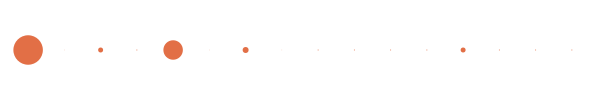

In [98]:
N=4
depth = 5
s = siteinds("Qubit", N)

psi, bit_flip_qubit, bit_flip_location = run_with_bit_flip_error(N, depth, theta1, phi1, theta2);
print("bit_flip_qubit: ")
println(bit_flip_qubit)
print("bit_flip_location: ")
println(bit_flip_location)

squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]

Plots.scatter([i for i in 1:2^N], zeros(2^N), 
    markersize=squared_mag*40,markercolor	=2,markerstrokecolor=2,
    ylims=(-0.5, 0.5), axis=false, ticks = false, size = (600, 100), legend=false)

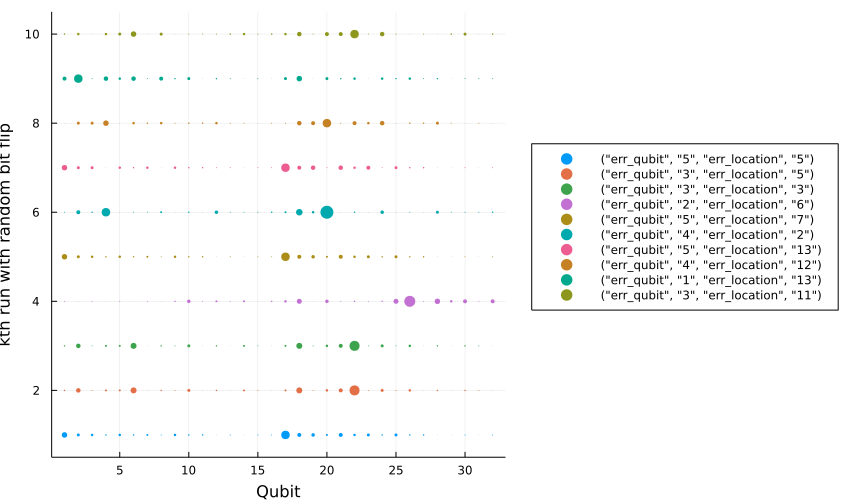

In [99]:
Plots.gr()
l = @layout [a{1h}; b c{1w}]

N=5
depth = 2
s = siteinds("Qubit", N)

max_k = 10

k=1
psi, bit_flip_qubit, bit_flip_location = run_with_bit_flip_error(N, depth, theta1, phi1, theta2);
squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]
Plots.scatter([j for j in 1:2^N], ones(2^N)*k, 
    markersize=squared_mag*40,markercolor	=k,markerstrokecolor=k,
    ylims=(0.5, 1.5), axis=true, ticks = true, size = (500, 800), 
    legend=true, label=("err_qubit",bit_flip_qubit,"err_location",bit_flip_location))

for k in 2:max_k
    psi, bit_flip_qubit, bit_flip_location = run_with_bit_flip_error(N, depth, theta1, phi1, theta2);
    squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]
       
    
    Plots.scatter!([j for j in 1:2^N], ones(2^N)*k, 
        markersize=squared_mag*40,markercolor	=k,markerstrokecolor=k,
        ylims=(0.5, max_k+0.5), axis=true, ticks = true, size = (850, 50*max_k), 
        label=("err_qubit",bit_flip_qubit,"err_location",bit_flip_location), legend=:outerright)
end

ylabel!("kth run with random bit flip")
xlabel!("Qubit")
current()